In this notebook the optimal weights for bagging are found using bayesian optimization.

In [1]:
import numpy as np
import pandas as pd

#surprise package imports
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader

from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import KNNWithZScore
from surprise import CoClustering

#bayes_opt imports
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events

import json
import csv

In [2]:
def create_pd_df(predictions):
    '''Creates a pandas DataFrame with columns uid, iid and predictions. Input is a surprise predictions list'''
    UID=[]
    IID=[]
    prediction=[]
    for uid,iid,r_ui,est,_ in predictions:
        UID.append(uid)
        IID.append(iid)
        prediction.append(est)
    return  pd.DataFrame(np.transpose([UID,IID,prediction]),columns=['uid','iid','prediction'])

def get_real_rating(predictions):
    '''gets the real ratings from surprise predictions, this function is used to 
    calculate the rmse when bagging is used '''
    real=[]
    for uid,iid,r_ui,est,_ in predictions:
        real.append(r_ui)
    return real


def bagging_weighted_sum(algos, weights, names,trainset,testset,submission=False, submission_name=None):
    '''This functions creates the weighted sum of the predictions of different algorithems, if submission = True 
    a csv file to submit is created, if submission = False, the RMSE on the testset is given'''
    print('Fitting and predicting for algorithem 1...')
    prediction_0=algos[0].fit(trainset).test(testset)
    predictions_df=create_pd_df(prediction_0)
    predictions_df.columns=['uid','iid',names[0]]
    for i in range(1,len(algos)):
        print('Fitting and predicting for algorithm '+str(i+1)+'...')
        prediction_temp=create_pd_df(algos[i].fit(trainset).test(testset))
        predictions_df[names[i]]=prediction_temp['prediction']
    print('gathered all predictions, calculating weighted sum...')
    
    comp_prediction=np.zeros(len(predictions_df['uid']))
    for i in range(0, len(names)):
        comp_prediction=comp_prediction+weights[i]*predictions_df[names[i]].astype(float)
    comb_prediction_df=pd.DataFrame(np.transpose([predictions_df.uid,predictions_df.iid,comp_prediction]),columns=['uid','iid','prediction'])
    
    if submission == False:
        print('calculating test rmse...')
        comb_prediction_df['real_rating']=get_real_rating(prediction_0)
        return np.sqrt(mean_squared_error(comb_prediction_df.real_rating.values.astype(int),comb_prediction_df.prediction.values.astype(float)))
    
    elif submission == True:
        print('creating submission csv...')
        pos="r"+comb_prediction_df.uid.astype(float).astype(int).astype(str)+"_c"+comb_prediction_df.iid.astype(float).astype(int).astype(str)
        prediction=comb_prediction_df.prediction.astype(float).round(0).astype(int)
        pos=list(pos.values)
        prediction=list(prediction.values)
        pos.insert(0,'Id')
        prediction.insert(0,'Prediction')
        with open('submission_combined_'+submission_name+'.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerows(zip(pos, prediction))
        print('submission csv created')

def get_opt_parameters(json_file_name):
    '''This function reads the json file provided by the bayesian-optimization package and returns the optimal parametrs'''
    with open(json_file_name, 'r') as handle:
        json_data = [json.loads(line) for line in handle]
    rmse=[]
    for d in json_data:
        rmse.append(d.get('target'))
    index=np.where(rmse==np.max(rmse))[0][0]
    return json_data[index].get('params')


In [3]:
reader = Reader(line_format='user item rating', sep='\t')
data = Dataset.load_from_file('ratings.csv', reader=reader)

## Ridge Regression

In [4]:
op_KNNWithZScoreItemPearson=get_opt_parameters('./outputs/logsKNNWithZScoreItemPearson.json')
op_KNNWithMeansItemPearson=get_opt_parameters('./outputs/logsKNNWithMeansItemPearson.json')
op_KNNWithZScoreUserPearsonBaseline=get_opt_parameters('./outputs/logsKNNWithZScoreUserPearsonBaseline.json')
op_KNNWithMeansUserPearsonBaseline=get_opt_parameters('./outputs/logsKNNWithMeansUserPearsonBaseline.json')
op_NMFUnBiased=get_opt_parameters('./outputs/logsNMFUnBiased.json')
op_SVDBiased=get_opt_parameters('./outputs/logsSVDBiased.json')
op_CoCl=get_opt_parameters("./outputs/logsCoCl.json")


KNNWithZScoreItemPearson=KNNWithZScore(k=int(op_KNNWithZScoreItemPearson.get('k')), min_k=int(op_KNNWithZScoreItemPearson.get('min_k')), sim_options={'name': 'pearson',
                   'min_support': int(op_KNNWithZScoreItemPearson.get('min_support')),
                   'user_based': False},bsl_options = {'method': 'als',
               'n_epochs': int(op_KNNWithZScoreItemPearson.get('n_epochs')),
               'reg_u': op_KNNWithZScoreItemPearson.get('reg_u'),
               'reg_i': op_KNNWithZScoreItemPearson.get('reg_i')
               } ,verbose=False)
KNNWithMeansItemPearson= KNNWithMeans(k=int(op_KNNWithMeansItemPearson.get('k')), min_k=int(op_KNNWithMeansItemPearson.get('min_k')), sim_options= {'name': 'pearson',
                   'min_support':int(op_KNNWithMeansItemPearson.get('min_support')),
                   'user_based': False}, bsl_options = {'method': 'als',
               'n_epochs': int(op_KNNWithMeansItemPearson.get('n_epochs')),
               'reg_u': op_KNNWithMeansItemPearson.get('reg_u'),
               'reg_i': op_KNNWithMeansItemPearson.get('reg_i')
               } ,verbose=False)

KNNWithZScoreUserPearsonBaseline=KNNWithZScore(k=int(op_KNNWithZScoreUserPearsonBaseline.get('k')), min_k=int(op_KNNWithZScoreUserPearsonBaseline.get('min_k')), sim_options={'name': 'pearson_baseline',
                   'min_support':int(op_KNNWithZScoreUserPearsonBaseline.get('min_support')),
                   'shrinkage':op_KNNWithZScoreUserPearsonBaseline.get('shrinkage'),
                   'user_based': True
               },bsl_options={'method': 'als',
               'n_epochs': int(op_KNNWithZScoreUserPearsonBaseline.get('n_epochs')),
               'reg_u': op_KNNWithZScoreUserPearsonBaseline.get('reg_u'),
               'reg_i': op_KNNWithZScoreUserPearsonBaseline.get('reg_i')
               }, verbose=False)
KNNWithMeansUserPearsonBaseline=KNNWithMeans(k=int(op_KNNWithMeansUserPearsonBaseline.get('k')), min_k=int(op_KNNWithMeansUserPearsonBaseline.get('min_k')), sim_options={'name': 'pearson_baseline',
                   'min_support':int(op_KNNWithMeansUserPearsonBaseline.get('min_support')),
                   'shrinkage':op_KNNWithMeansUserPearsonBaseline.get('shrinkage'),
                   'user_based': True
               },bsl_options={'method': 'als',
               'n_epochs': int(op_KNNWithMeansUserPearsonBaseline.get('n_epochs')),
               'reg_u': op_KNNWithMeansUserPearsonBaseline.get('reg_u'),
               'reg_i': op_KNNWithMeansUserPearsonBaseline.get('reg_i')
               }, verbose=False)
NMFUnBiased=NMF(n_factors=int(op_NMFUnBiased.get('n_factors')),lr_bu=op_NMFUnBiased.get('lr_bu'),reg_qi=op_NMFUnBiased.get('reg_qi'),
               reg_bu=op_NMFUnBiased.get('reg_bu'),n_epochs=int(op_NMFUnBiased.get('n_epochs')),biased=False)
SVDBiased=SVD(n_factors=int(op_SVDBiased.get('n_factors')),lr_pu=op_SVDBiased.get('lr_pu'),lr_bu=op_SVDBiased.get('lr_bu'),lr_bi=op_SVDBiased.get('lr_bi'),reg_qi=op_SVDBiased.get('reg_qi'),
               reg_bu=op_SVDBiased.get('reg_bu'),reg_bi=op_SVDBiased.get('reg_bi'),reg_pu=op_SVDBiased.get('reg_pu'),n_epochs=int(op_SVDBiased.get('n_epochs')),biased=True)
CoCl=CoClustering(n_epochs=int(op_CoCl.get('n_epochs')),n_cltr_u=int(op_CoCl.get('n_cltr_u')),n_cltr_i=int(op_CoCl.get('n_cltr_i')))

algos=[KNNWithZScoreItemPearson,KNNWithMeansItemPearson,KNNWithZScoreUserPearsonBaseline,KNNWithMeansUserPearsonBaseline,NMFUnBiased,SVDBiased,CoCl]
names=['KNNWithZScoreItemPearson','KNNWithMeansItemPearson','KNNWithZScoreUserPearsonBaseline','KNNWithMeansUserPearsonBaseline','NMFUnBiased','SVDBiased','CoCl']


In [5]:
def get_X_y(algos, names,trainset,testset):
    '''Returns a df containing all '''
    print('Fitting and predicting for algorithem 1...')
    prediction_0=algos[0].fit(trainset).test(testset)
    predictions_df=create_pd_df(prediction_0)
    predictions_df.columns=['uid','iid',names[0]]
    for i in range(1,len(algos)):
        print('Fitting and predicting for algorithm '+str(i+1)+'...')
        prediction_temp=create_pd_df(algos[i].fit(trainset).test(testset))
        predictions_df[names[i]]=prediction_temp['prediction']
    print('gathered all predictions, getting real ratings')
    y=get_real_rating(prediction_0)
    return predictions_df ,y 

In [6]:
full_trainset=data.build_full_trainset()
submission_test = Dataset.load_from_file('sub.csv', reader=reader)
submission_full_train=submission_test.build_full_trainset()
submission_full_testset=submission_full_train.build_testset()

In [7]:
trainset, testset = train_test_split(data, test_size=.3)

In [8]:
X,y=get_X_y(algos,names,trainset,testset)

Fitting and predicting for algorithem 1...
Fitting and predicting for algorithm 2...
Fitting and predicting for algorithm 3...
Fitting and predicting for algorithm 4...
Fitting and predicting for algorithm 5...
Fitting and predicting for algorithm 6...
Fitting and predicting for algorithm 7...
gathered all predictions, getting real ratings


In [9]:
from sklearn.linear_model import RidgeCV

In [10]:
alphas=np.logspace(-3,np.log10(10),1000) #we use logspace so we can start close to 0 
regressor = RidgeCV(alphas=alphas, store_cv_values=True, cv=None) #if we have cv=none default scoring is MSE
regressor.fit(X[names], y)


RidgeCV(alphas=array([1.00000000e-03, 1.00926219e-03, 1.01861017e-03, 1.02804473e-03,
       1.03756668e-03, 1.04717682e-03, 1.05687597e-03, 1.06666496e-03,
       1.07654461e-03, 1.08651577e-03, 1.09657929e-03, 1.10673602e-03,
       1.11698682e-03, 1.12733256e-03, 1.13777413e-03, 1.14831241e-03,
       1.15894830e-03, 1.16968270e-03, 1.18051653e-03, 1.19145070e-03,
       1.20248614e-03, 1.21362380e-0...
       8.39312950e+00, 8.47086827e+00, 8.54932707e+00, 8.62851257e+00,
       8.70843150e+00, 8.78909065e+00, 8.87049689e+00, 8.95265713e+00,
       9.03557835e+00, 9.11926760e+00, 9.20373200e+00, 9.28897872e+00,
       9.37501502e+00, 9.46184819e+00, 9.54948564e+00, 9.63793480e+00,
       9.72720319e+00, 9.81729841e+00, 9.90822810e+00, 1.00000000e+01]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=True)

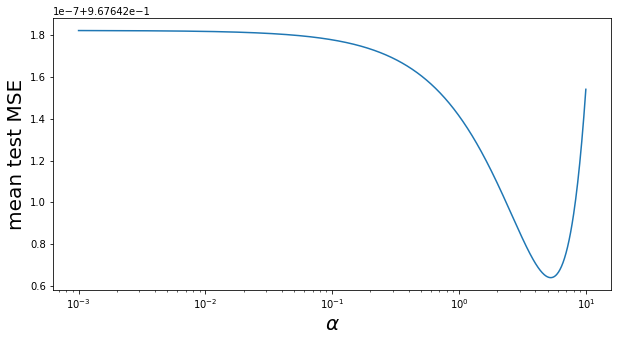

In [11]:
cv_mse = np.mean(regressor.cv_values_, axis=0)
#ploting CV error (MSE) vs. alpha
plt.figure(figsize=(10,5))
plt.semilogx(alphas,np.abs(cv_mse))
plt.ylabel('CV MSE', fontsize=20)
plt.xlabel(r'$\lambda$', fontsize=20)
plt.show()

In [12]:
print('The best alpha is:', regressor.alpha_)

The best alpha is: 5.293266058360562


In [13]:
X_sub,y_sub=get_X_y(algos,names,full_trainset,submission_full_testset)

Fitting and predicting for algorithem 1...
Fitting and predicting for algorithm 2...
Fitting and predicting for algorithm 3...
Fitting and predicting for algorithm 4...
Fitting and predicting for algorithm 5...
Fitting and predicting for algorithm 6...
Fitting and predicting for algorithm 7...
gathered all predictions, getting real ratings


In [14]:
y_hat=regressor.predict(X_sub[names])

In [16]:
df_submission=pd.DataFrame(data=np.transpose([X_sub['uid'],X_sub['iid'],y_hat]), columns=['uid','iid','prediction'])
pos=[]
prediction=[]
for i in range(0,len(y_hat)):
    pos.append("r"+str((int(float(df_submission.loc[i,'uid']))))+"_c"+str(int(float(df_submission.loc[i,'iid']))))
    prediction.append(round(df_submission.loc[i,'prediction']))
pos.insert(0,'Id')
prediction.insert(0,'Prediction')
with open('submission_ridge.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(pos, prediction))

In [20]:
submission_ridge_parameters = dict()
submission_ridge_parameters={
    'X':X,
    'y':y,
    'X_sub': X_sub,
    'alpha': regressor.alpha_,
    'coefficient': regressor.coef_,
    'intercept': regressor.intercept_
}
np.save('outputs/submission_ridge_parameters.npy', submission_ridge_parameters) 